In [1]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-11-17 10:39:19.411129: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 10:39:19.948726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-17 10:39:20.511759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 10:39:20.534583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [5]:
tf.keras.backend.clear_session()

In [6]:
subject = 'Paraíba - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [7]:
data = pd.read_csv('2003_mo_model_input_PB.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Paraíba- custo m2 (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - IDH,Paraíba - IDH Longevidade,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita,Paraíba - PIB - Preços de Mercado,Paraíba - IDH Renda,Paraíba - Consumo de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,9766.671600,8.315958,118.926160,0.182304,1.190368,948.129859,1343.725535,22.497513,19.371613,84.002026,4.942143,0.592931,0.656510,0.753966,1.938190e+06,3.017292e+07,1.631334e+06,7.291169,2.736342e+07,0.600949,38.426,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,9857.678138,8.309895,117.724891,0.185909,1.190430,948.130898,1343.725535,22.497092,19.371751,84.004982,4.939870,0.593396,0.656949,0.754445,1.949292e+06,3.021010e+07,1.632950e+06,7.293438,2.737516e+07,0.601441,31.672,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,9943.113694,8.303831,118.501965,0.189593,1.190466,948.131504,1343.725535,22.496846,19.371831,84.006706,4.938543,0.593862,0.657388,0.754925,1.960394e+06,3.024728e+07,1.634566e+06,7.295708,2.738689e+07,0.601934,28.775,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,10021.544051,8.297767,119.390679,0.193353,1.190470,948.131569,1343.725535,22.496820,19.371840,84.006891,4.938401,0.594327,0.657827,0.755404,1.971496e+06,3.028445e+07,1.636182e+06,7.297978,2.739862e+07,0.602426,28.571,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,10097.066120,8.291704,121.517541,0.197186,1.212656,948.032498,1337.766989,22.616890,19.394367,83.575985,4.915516,0.594792,0.658266,0.755883,1.982599e+06,3.032163e+07,1.637798e+06,7.300247,2.741035e+07,0.602918,31.613,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,35014.601037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,34990.882752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,34927.562237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,34834.566845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


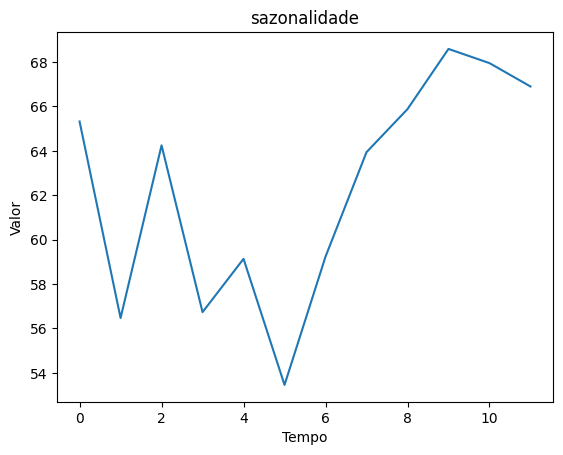

,sazonalidade
sazonalidade,
0,65.322910
1,56.470275
2,64.249239
3,56.734377
4,59.136654
5,53.455721
6,59.236248
7,63.942683
8,65.881624


In [8]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [9]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Paraíba- custo m2 (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - IDH,Paraíba - IDH Longevidade,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita,Paraíba - PIB - Preços de Mercado,Paraíba - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Paraíba - Consumo de Cimento (t)
0,2003-1,9766.671600,8.315958,118.926160,0.182304,1.190368,948.129859,1343.725535,22.497513,19.371613,84.002026,4.942143,0.592931,0.656510,0.753966,1.938190e+06,3.017292e+07,1.631334e+06,7.291169,2.736342e+07,0.600949,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,65.322910,38.426
1,2003-2,9857.678138,8.309895,117.724891,0.185909,1.190430,948.130898,1343.725535,22.497092,19.371751,84.004982,4.939870,0.593396,0.656949,0.754445,1.949292e+06,3.021010e+07,1.632950e+06,7.293438,2.737516e+07,0.601441,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,56.470275,31.672
2,2003-3,9943.113694,8.303831,118.501965,0.189593,1.190466,948.131504,1343.725535,22.496846,19.371831,84.006706,4.938543,0.593862,0.657388,0.754925,1.960394e+06,3.024728e+07,1.634566e+06,7.295708,2.738689e+07,0.601934,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,64.249239,28.775
3,2003-4,10021.544051,8.297767,119.390679,0.193353,1.190470,948.131569,1343.725535,22.496820,19.371840,84.006891,4.938401,0.594327,0.657827,0.755404,1.971496e+06,3.028445e+07,1.636182e+06,7.297978,2.739862e+07,0.602426,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,56.734377,28.571
4,2003-5,10097.066120,8.291704,121.517541,0.197186,1.212656,948.032498,1337.766989,22.616890,19.394367,83.575985,4.915516,0.594792,0.658266,0.755883,1.982599e+06,3.032163e+07,1.637798e+06,7.300247,2.741035e+07,0.602918,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,59.136654,31.613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,35014.601037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.136654,NaN
245,2023-6,34990.882752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.455721,NaN
246,2023-7,34927.562237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.236248,NaN
247,2023-8,34834.566845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.942683,NaN


In [10]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      32.450
1      27.763
2      30.131
3      27.103
4      28.053
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Paraíba - Consumo de Cimento (t), Length: 249, dtype: float64

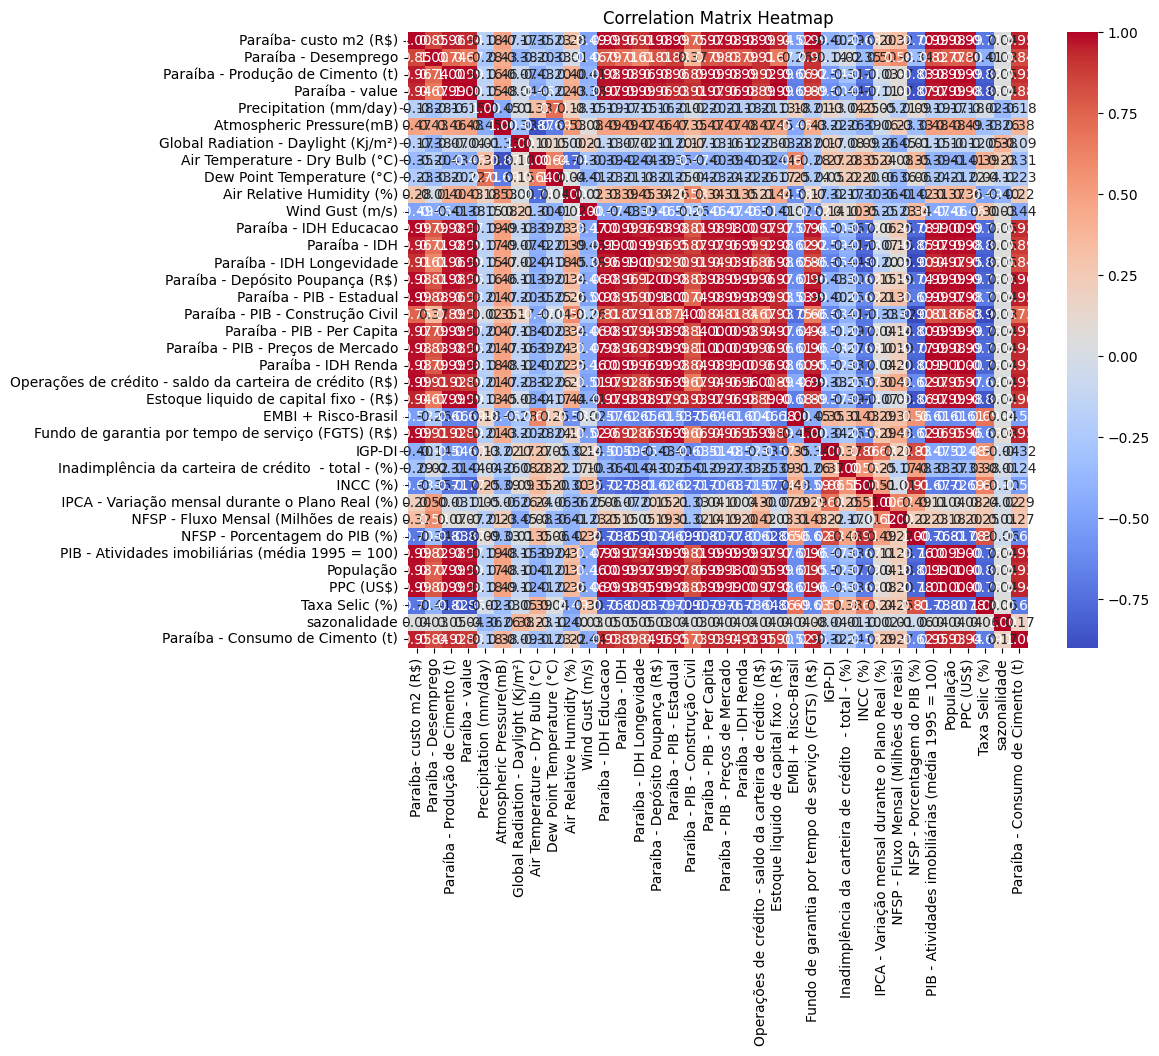

In [11]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [13]:
safe_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Paraíba- custo m2 (R$),2.410856e+06
1,Paraíba - Desemprego,4.190842e+05
2,Paraíba - Produção de Cimento (t),1.589853e+05
3,Paraíba - value,2.754594e+05
4,Precipitation (mm/day),3.212222e+02
5,Atmospheric Pressure(mB),7.295415e+07
6,Global Radiation - Daylight (Kj/m²),1.127523e+03
7,Air Temperature - Dry Bulb (°C),5.140568e+06
8,Dew Point Temperature (°C),3.919231e+06
9,Air Relative Humidity (%),3.728622e+06


In [14]:
data =data.drop(['Global Radiation - Daylight (Kj/m²)',
                 'Air Relative Humidity (%)',
                 'Paraíba - IDH Longevidade',
                 'Paraíba - IDH Renda',
                 'Paraíba - Depósito Poupança (R$)',
                 'Paraíba - PIB - Estadual', 
                 'Inadimplência da carteira de crédito  - total - (%)',
                 'Paraíba - PIB - Per Capita',
                 'Paraíba - PIB - Preços de Mercado'], axis=1)
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 7


,Paraíba- custo m2 (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,9766.671600,8.315958,118.926160,0.182304,1.190368,948.129859,1343.725535,22.497513,19.371613,84.002026,4.942143,0.592931,1.938190e+06,3.017292e+07,1.631334e+06,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,65.322910
1,9857.678138,8.309895,117.724891,0.185909,1.190430,948.130898,1343.725535,22.497092,19.371751,84.004982,4.939870,0.593396,1.949292e+06,3.021010e+07,1.632950e+06,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,56.470275
2,9943.113694,8.303831,118.501965,0.189593,1.190466,948.131504,1343.725535,22.496846,19.371831,84.006706,4.938543,0.593862,1.960394e+06,3.024728e+07,1.634566e+06,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,64.249239
3,10021.544051,8.297767,119.390679,0.193353,1.190470,948.131569,1343.725535,22.496820,19.371840,84.006891,4.938401,0.594327,1.971496e+06,3.028445e+07,1.636182e+06,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,56.734377
4,10097.066120,8.291704,121.517541,0.197186,1.212656,948.032498,1337.766989,22.616890,19.394367,83.575985,4.915516,0.594792,1.982599e+06,3.032163e+07,1.637798e+06,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,59.136654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,21360.805168,11.157577,188.999647,0.558286,0.814094,949.772265,1080.280679,21.925868,18.545990,83.272850,4.275308,0.650539,4.673300e+06,3.598256e+07,1.718131e+06,3.143856e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,390.589413,1.078474,63.942683
152,21454.482107,11.167527,189.643484,0.558862,0.871842,949.548815,1140.414419,22.281904,18.612566,82.128186,4.200416,0.651576,4.663800e+06,3.599662e+07,1.717001e+06,3.159665e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,391.798431,0.962516,65.881624
153,21553.595224,11.177478,190.269914,0.559453,1.026922,949.199880,1152.035486,22.570673,18.912236,82.224384,3.964329,0.652612,4.654299e+06,3.601068e+07,1.715871e+06,3.177292e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,393.032398,1.138989,68.593190
154,21644.517382,11.187428,190.509927,0.560071,1.055278,948.883479,1155.387533,22.806023,19.254503,82.715662,3.814788,0.653648,4.644798e+06,3.602474e+07,1.714741e+06,3.192250e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,394.326420,1.038436,67.953488


In [15]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-0.577751,-2.045245,-2.225157,-0.075451,-0.094686,0.847631,-0.145947,-0.099733,0.073801,1.274219,-1.886582,-1.549037,-1.568127,-2.282324,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,-0.582744,-2.098404,-2.193108,-0.075153,-0.093589,0.847631,-0.146409,-0.099498,0.074733,1.268756,-1.857533,-1.538039,-1.548170,-2.239248,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,-0.587736,-2.064017,-2.160357,-0.074979,-0.092949,0.847631,-0.146678,-0.099360,0.075277,1.265570,-1.828484,-1.527040,-1.528214,-2.196172,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,-0.592729,-2.024689,-2.126930,-0.074961,-0.092881,0.847631,-0.146707,-0.099346,0.075335,1.265228,-1.799434,-1.516042,-1.508257,-2.153095,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,-0.597722,-1.930570,-2.092854,0.031334,-0.197476,0.812740,-0.015138,-0.060825,-0.060567,1.210245,-1.770385,-1.505043,-1.488300,-2.110019,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1.762010,1.055672,1.117554,-1.878186,1.639291,-0.695028,-0.772335,-1.511556,-0.156171,-0.327919,1.710487,1.160555,1.550498,0.031390,1.823582,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.398025,0.209123
152,1.770203,1.084164,1.122673,-1.601515,1.403382,-0.342902,-0.382204,-1.397712,-0.517182,-0.507854,1.775199,1.151143,1.558045,0.001265,1.841017,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.415152,-0.182135
153,1.778396,1.111885,1.127927,-0.858520,1.034992,-0.274852,-0.065781,-0.885272,-0.486843,-1.075075,1.839910,1.141731,1.565592,-0.028860,1.860456,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.432633,0.413308
154,1.786589,1.122506,1.133426,-0.722670,0.700951,-0.255223,0.192107,-0.299993,-0.331901,-1.434362,1.904622,1.132319,1.573140,-0.058985,1.876950,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.450965,0.074029


In [16]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-0.577751,-2.045245,-2.225157,-0.075451,-0.094686,0.847631,-0.145947,-0.099733,0.073801,1.274219,-1.886582,-1.549037,-1.568127,-2.282324,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,-0.582744,-2.098404,-2.193108,-0.075153,-0.093589,0.847631,-0.146409,-0.099498,0.074733,1.268756,-1.857533,-1.538039,-1.548170,-2.239248,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,-0.587736,-2.064017,-2.160357,-0.074979,-0.092949,0.847631,-0.146678,-0.099360,0.075277,1.265570,-1.828484,-1.527040,-1.528214,-2.196172,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,-0.592729,-2.024689,-2.126930,-0.074961,-0.092881,0.847631,-0.146707,-0.099346,0.075335,1.265228,-1.799434,-1.516042,-1.508257,-2.153095,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,-0.597722,-1.930570,-2.092854,0.031334,-0.197476,0.812740,-0.015138,-0.060825,-0.060567,1.210245,-1.770385,-1.505043,-1.488300,-2.110019,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.625775,1.058132,1.047327,-0.602045,1.589646,-1.079483,-1.230853,-1.817897,-0.034540,-0.497353,1.208902,1.306293,1.432184,0.404439,1.517172,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.245801,-0.282621
140,1.641551,1.065363,1.053295,-0.648950,1.230893,-0.812348,-0.893847,-1.629973,-0.291544,-0.572279,1.218623,1.290322,1.445281,0.372004,1.549848,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.254608,-0.612121
141,1.657328,1.073004,1.059520,-0.571806,1.035576,-0.438301,-0.576588,-1.401964,-0.508276,-0.546341,1.228343,1.274351,1.458378,0.339569,1.588878,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.263636,-0.137902
142,1.673104,1.080998,1.065656,-0.371719,0.644773,-0.201289,-0.100617,-0.953924,-0.772303,-0.929697,1.238063,1.258381,1.471475,0.307134,1.625721,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.272935,-0.332143


In [17]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      32.450000
1      27.763000
2      30.131000
3      27.103000
4      28.053000
         ...    
139    82.914803
140    83.712686
141    86.983621
142    84.940831
143    75.419000
Name: Paraíba - Consumo de Cimento (t), Length: 144, dtype: float64

In [18]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [19]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 26)

In [20]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
108,0.941088,1.107791,0.776341,0.640612,-0.580590,1.042335,0.006204,0.846049,0.735570,0.127399,0.692172,0.770314,0.771865,1.130260,0.595959,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.812014,-1.082183
109,0.962640,1.086973,0.788542,0.600374,-0.463918,0.850894,0.080554,0.890030,0.675835,-0.008367,0.706582,0.805079,0.797594,1.105506,0.621380,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.831569,-1.036767
110,0.984192,1.094172,0.800207,0.575515,-0.043488,0.364589,-0.067068,0.812070,0.813912,-0.296637,0.720991,0.839844,0.823323,1.080752,0.652999,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.850791,-0.752482
111,1.005744,1.077277,0.811762,0.881648,0.397814,-0.299327,-0.479729,0.481163,1.085523,-0.418845,0.735400,0.874609,0.849052,1.055997,0.685630,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.868783,-1.088413
112,1.027296,1.089821,0.822761,0.216984,1.116065,-0.679079,-1.037810,-0.104792,1.303109,-0.187120,0.749810,0.909374,0.874781,1.031243,0.717515,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.886720,-1.508135
113,1.048848,1.091788,0.833649,-0.125247,1.655602,-0.770883,-1.395840,-0.720983,1.231298,0.071451,0.764219,0.944140,0.900510,1.006489,0.747579,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.905151,-1.474280
114,1.070401,1.133654,0.842737,-1.075835,1.674962,-0.630092,-1.469144,-1.187457,0.912776,0.548557,0.778628,0.978905,0.926239,0.981735,0.775262,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.923702,-1.463452
115,1.091953,1.133910,0.850916,-1.913058,1.406972,-0.262886,-1.156387,-1.373890,0.341727,0.423212,0.793037,1.013670,0.951968,0.956981,0.805205,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.942382,-1.236037
116,1.113505,1.120983,0.858494,-2.328570,0.788471,-0.059141,-0.640951,-1.124946,-0.106366,0.207841,0.807447,1.048435,0.977697,0.932227,0.836796,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.960385,-0.935721
117,1.135057,1.111372,0.865574,-2.473201,0.179981,0.080518,-0.129075,-0.650793,-0.347751,-0.064025,0.821856,1.083200,1.003426,0.907473,0.876422,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.977769,-1.241995


In [21]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 26)

In [22]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [23]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
#     train, train_val = validation_splitter(train_input, 7)
#     target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(144, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01),
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(144, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(36, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
#                         validation_data=(train_val,
#                                          target_val),
                        validation_split=0.15,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [24]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(5)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [25]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1278562434, 3411214999, 3481183209, 3443513263, 4136679558]


Step: 0 ___________________________________________


2023-11-17 10:39:23.172220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 10:39:23.172429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 10:39:23.172614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

val_loss: 305.2666320800781
winner_seed: 1278562434


Step: 1 ___________________________________________
val_loss: 125.99859619140625
winner_seed: 3411214999


Step: 2 ___________________________________________
val_loss: 245.4622039794922


Step: 3 ___________________________________________
val_loss: 84.707275390625
winner_seed: 3443513263


Step: 4 ___________________________________________
val_loss: 72.66221618652344
winner_seed: 4136679558


final_seed: 4136679558


In [26]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 1037461789

Epoch 1/10000
3/3 [==============================] - 3s 257ms/step - loss: 6715.0796 - val_loss: 3628.8882
Epoch 2/10000
3/3 [==============================] - 0s 15ms/step - loss: 2391.8782 - val_loss: 534.0720
Epoch 3/10000
3/3 [==============================] - 0s 15ms/step - loss: 611.1708 - val_loss: 196.7385
Epoch 4/10000
3/3 [==============================] - 0s 15ms/step - loss: 459.6347 - val_loss: 156.7296
Epoch 5/10000
3/3 [==============================] - 0s 15ms/step - loss: 445.5513 - val_loss: 150.7216
Epoch 6/10000
3/3 [==============================] - 0s 14ms/step - loss: 444.6841 - val_loss: 151.3542
Epoch 7/10000
3/3 [==============================] - 0s 15ms/step - loss: 444.3418 - val_loss: 153.0342
Epoch 8/10000
3/3 [==============================] - 0s 16ms/step - loss: 444.1888 - val_loss: 148.4108
Epoch 9/10000
3/3 [==============================] - 0s 16ms/step - loss: 444.3943 - val_loss: 153.7601
Epoch 10/10000
3/3 [==============================] - 0s 15m

3/3 [==============================] - 0s 15ms/step - loss: 100.9115 - val_loss: 534.7101
Epoch 80/10000
3/3 [==============================] - 0s 16ms/step - loss: 104.9098 - val_loss: 557.8176
Epoch 81/10000
3/3 [==============================] - 0s 17ms/step - loss: 98.6131 - val_loss: 540.3971
Epoch 82/10000
3/3 [==============================] - 0s 15ms/step - loss: 96.8748 - val_loss: 559.5787
Epoch 83/10000
3/3 [==============================] - 0s 16ms/step - loss: 95.7568 - val_loss: 541.3132
Epoch 84/10000
3/3 [==============================] - 0s 16ms/step - loss: 98.4468 - val_loss: 543.6785
Epoch 85/10000
3/3 [==============================] - 0s 15ms/step - loss: 97.0371 - val_loss: 547.0917
Epoch 86/10000
3/3 [==============================] - 0s 15ms/step - loss: 96.4736 - val_loss: 543.4145
Epoch 87/10000
3/3 [==============================] - 0s 15ms/step - loss: 94.9568 - val_loss: 536.8889
Epoch 88/10000
3/3 [==============================] - 0s 15ms/step - loss: 10

3/3 [==============================] - 0s 14ms/step - loss: 83.0465 - val_loss: 533.3069
Epoch 158/10000
3/3 [==============================] - 0s 14ms/step - loss: 87.1883 - val_loss: 556.5940
Epoch 159/10000
3/3 [==============================] - 0s 15ms/step - loss: 84.5480 - val_loss: 538.3358
Epoch 160/10000
3/3 [==============================] - 0s 15ms/step - loss: 86.1616 - val_loss: 530.6782
Epoch 161/10000
3/3 [==============================] - 0s 14ms/step - loss: 86.3606 - val_loss: 545.4514
Epoch 162/10000
3/3 [==============================] - 0s 15ms/step - loss: 83.0405 - val_loss: 548.0408
Epoch 163/10000
3/3 [==============================] - 0s 15ms/step - loss: 86.9096 - val_loss: 553.4866
Epoch 164/10000
3/3 [==============================] - 0s 16ms/step - loss: 85.9691 - val_loss: 562.6453
Epoch 165/10000
3/3 [==============================] - 0s 15ms/step - loss: 87.5938 - val_loss: 542.2448
Epoch 166/10000
3/3 [==============================] - 0s 16ms/step - l

3/3 [==============================] - 0s 15ms/step - loss: 62.2379 - val_loss: 272.5200
Epoch 236/10000
3/3 [==============================] - 0s 15ms/step - loss: 60.4278 - val_loss: 495.8605
Epoch 237/10000
3/3 [==============================] - 0s 14ms/step - loss: 91.1225 - val_loss: 304.0710
Epoch 238/10000
3/3 [==============================] - 0s 15ms/step - loss: 70.5950 - val_loss: 263.5121
Epoch 239/10000
3/3 [==============================] - 0s 14ms/step - loss: 65.6159 - val_loss: 258.7220
Epoch 240/10000
3/3 [==============================] - 0s 14ms/step - loss: 61.0150 - val_loss: 205.9796
Epoch 241/10000
3/3 [==============================] - 0s 17ms/step - loss: 59.1774 - val_loss: 168.4278
Epoch 242/10000
3/3 [==============================] - 0s 15ms/step - loss: 73.4293 - val_loss: 450.2648
Epoch 243/10000
3/3 [==============================] - 0s 16ms/step - loss: 73.8565 - val_loss: 355.1584
Epoch 244/10000
3/3 [==============================] - 0s 15ms/step - l

3/3 [==============================] - 0s 14ms/step - loss: 46.3947 - val_loss: 158.7246
Epoch 314/10000
3/3 [==============================] - 0s 15ms/step - loss: 52.0062 - val_loss: 131.9482
Epoch 315/10000
3/3 [==============================] - 0s 14ms/step - loss: 45.3366 - val_loss: 137.7802
Epoch 316/10000
3/3 [==============================] - 0s 14ms/step - loss: 47.2407 - val_loss: 148.8507
Epoch 317/10000
3/3 [==============================] - 0s 14ms/step - loss: 43.6494 - val_loss: 145.3838
Epoch 318/10000
3/3 [==============================] - 0s 15ms/step - loss: 44.5867 - val_loss: 173.3683
Epoch 319/10000
3/3 [==============================] - 0s 15ms/step - loss: 44.9560 - val_loss: 125.4609
Epoch 320/10000
3/3 [==============================] - 0s 15ms/step - loss: 46.4323 - val_loss: 155.9627
Epoch 321/10000
3/3 [==============================] - 0s 15ms/step - loss: 45.9315 - val_loss: 141.5973
Epoch 322/10000
3/3 [==============================] - 0s 14ms/step - l

3/3 [==============================] - 0s 15ms/step - loss: 39.7901 - val_loss: 164.1026
Epoch 392/10000
3/3 [==============================] - 0s 16ms/step - loss: 38.9318 - val_loss: 148.1785
Epoch 393/10000
3/3 [==============================] - 0s 15ms/step - loss: 38.3719 - val_loss: 156.0731
Epoch 394/10000
3/3 [==============================] - 0s 15ms/step - loss: 38.0851 - val_loss: 162.7172
Epoch 395/10000
3/3 [==============================] - 0s 15ms/step - loss: 37.2876 - val_loss: 153.9001
Epoch 396/10000
3/3 [==============================] - 0s 15ms/step - loss: 37.4799 - val_loss: 124.0230
Epoch 397/10000
3/3 [==============================] - 0s 14ms/step - loss: 45.9384 - val_loss: 175.7783
Epoch 398/10000
3/3 [==============================] - 0s 15ms/step - loss: 37.0342 - val_loss: 177.0867
Epoch 399/10000
3/3 [==============================] - 0s 15ms/step - loss: 37.4872 - val_loss: 130.7943
Epoch 400/10000
3/3 [==============================] - 0s 14ms/step - l

3/3 [==============================] - 0s 16ms/step - loss: 34.0399 - val_loss: 183.3580
Epoch 470/10000
3/3 [==============================] - 0s 14ms/step - loss: 36.5509 - val_loss: 175.2193
Epoch 471/10000
3/3 [==============================] - 0s 14ms/step - loss: 33.9517 - val_loss: 183.4333
Epoch 472/10000
3/3 [==============================] - 0s 14ms/step - loss: 33.1350 - val_loss: 162.1615
Epoch 473/10000
3/3 [==============================] - 0s 14ms/step - loss: 33.7025 - val_loss: 181.3724
Epoch 474/10000
3/3 [==============================] - 0s 14ms/step - loss: 33.1552 - val_loss: 202.2014
Epoch 475/10000
3/3 [==============================] - 0s 16ms/step - loss: 33.2755 - val_loss: 154.7349
Epoch 476/10000
3/3 [==============================] - 0s 14ms/step - loss: 32.0509 - val_loss: 176.0048
Epoch 477/10000
3/3 [==============================] - 0s 16ms/step - loss: 33.7933 - val_loss: 168.0044
Epoch 478/10000
3/3 [==============================] - 0s 15ms/step - l

3/3 [==============================] - 0s 14ms/step - loss: 28.9748 - val_loss: 171.5930
Epoch 548/10000
3/3 [==============================] - 0s 14ms/step - loss: 28.1309 - val_loss: 164.0942
Epoch 549/10000
3/3 [==============================] - 0s 15ms/step - loss: 29.4610 - val_loss: 185.5700
Epoch 550/10000
3/3 [==============================] - 0s 15ms/step - loss: 29.1374 - val_loss: 182.6599
Epoch 551/10000
3/3 [==============================] - 0s 15ms/step - loss: 29.9581 - val_loss: 176.7373
Epoch 552/10000
3/3 [==============================] - 0s 15ms/step - loss: 28.1561 - val_loss: 174.7360
Epoch 553/10000
3/3 [==============================] - 0s 15ms/step - loss: 27.9220 - val_loss: 172.0159
Epoch 554/10000
3/3 [==============================] - 0s 15ms/step - loss: 28.1680 - val_loss: 180.2326
Epoch 555/10000
3/3 [==============================] - 0s 15ms/step - loss: 29.1497 - val_loss: 181.3152
Epoch 556/10000
3/3 [==============================] - 0s 15ms/step - l

3/3 [==============================] - 0s 14ms/step - loss: 28.6241 - val_loss: 150.5363
Epoch 626/10000
3/3 [==============================] - 0s 14ms/step - loss: 31.3221 - val_loss: 176.3211
Epoch 627/10000
3/3 [==============================] - 0s 16ms/step - loss: 28.9692 - val_loss: 177.4951
Epoch 628/10000
3/3 [==============================] - 0s 15ms/step - loss: 29.5863 - val_loss: 158.9296
Epoch 629/10000
3/3 [==============================] - 0s 15ms/step - loss: 26.9908 - val_loss: 197.0698
Epoch 630/10000
3/3 [==============================] - 0s 15ms/step - loss: 27.1189 - val_loss: 184.9912
Epoch 631/10000
3/3 [==============================] - 0s 14ms/step - loss: 26.9672 - val_loss: 144.1439
Epoch 632/10000
3/3 [==============================] - 0s 16ms/step - loss: 33.4737 - val_loss: 186.8260
Epoch 633/10000
3/3 [==============================] - 0s 15ms/step - loss: 30.6650 - val_loss: 117.2038
Epoch 634/10000
3/3 [==============================] - 0s 15ms/step - l

3/3 [==============================] - 0s 14ms/step - loss: 26.6057 - val_loss: 139.7450
Epoch 704/10000
3/3 [==============================] - 0s 14ms/step - loss: 27.5763 - val_loss: 147.5659
Epoch 705/10000
3/3 [==============================] - 0s 14ms/step - loss: 27.5324 - val_loss: 179.7975
Epoch 706/10000
3/3 [==============================] - 0s 16ms/step - loss: 27.7997 - val_loss: 225.5998
Epoch 707/10000
3/3 [==============================] - 0s 16ms/step - loss: 28.3383 - val_loss: 139.9498
Epoch 708/10000
3/3 [==============================] - 0s 15ms/step - loss: 26.5934 - val_loss: 178.4575
Epoch 709/10000
3/3 [==============================] - 0s 16ms/step - loss: 25.4308 - val_loss: 163.3124
Epoch 710/10000
3/3 [==============================] - 0s 16ms/step - loss: 25.2617 - val_loss: 139.8959
Epoch 711/10000
3/3 [==============================] - 0s 16ms/step - loss: 26.3664 - val_loss: 138.7220
Epoch 712/10000
3/3 [==============================] - 0s 15ms/step - l

3/3 [==============================] - 0s 15ms/step - loss: 28.3309 - val_loss: 134.6987
Epoch 782/10000
3/3 [==============================] - 0s 14ms/step - loss: 32.1397 - val_loss: 235.8654
Epoch 783/10000
3/3 [==============================] - 0s 14ms/step - loss: 29.1838 - val_loss: 169.0799
Epoch 784/10000
3/3 [==============================] - 0s 15ms/step - loss: 25.7442 - val_loss: 181.8671
Epoch 785/10000
3/3 [==============================] - 0s 16ms/step - loss: 26.4583 - val_loss: 189.2982
Epoch 786/10000
3/3 [==============================] - 0s 14ms/step - loss: 26.9137 - val_loss: 198.7484
Epoch 787/10000
3/3 [==============================] - 0s 14ms/step - loss: 23.5093 - val_loss: 174.2762
Epoch 788/10000
3/3 [==============================] - 0s 14ms/step - loss: 23.5085 - val_loss: 177.6086
Epoch 789/10000
3/3 [==============================] - 0s 14ms/step - loss: 25.0313 - val_loss: 155.3599
Epoch 790/10000
3/3 [==============================] - 0s 15ms/step - l

3/3 [==============================] - 0s 15ms/step - loss: 108.1488 - val_loss: 221.0605
Epoch 860/10000
3/3 [==============================] - 0s 15ms/step - loss: 96.9305 - val_loss: 286.7544
Epoch 861/10000
3/3 [==============================] - 0s 15ms/step - loss: 89.3985 - val_loss: 224.2779
Epoch 862/10000
3/3 [==============================] - 0s 16ms/step - loss: 98.9390 - val_loss: 357.4634
Epoch 863/10000
3/3 [==============================] - 0s 15ms/step - loss: 87.4684 - val_loss: 353.8616
Epoch 864/10000
3/3 [==============================] - 0s 16ms/step - loss: 85.2107 - val_loss: 364.9207
Epoch 865/10000
3/3 [==============================] - 0s 15ms/step - loss: 76.7848 - val_loss: 336.7160
Epoch 866/10000
3/3 [==============================] - 0s 15ms/step - loss: 79.9644 - val_loss: 336.2120
Epoch 867/10000
3/3 [==============================] - 0s 16ms/step - loss: 70.8813 - val_loss: 304.2221
Epoch 868/10000
3/3 [==============================] - 0s 14ms/step - 

3/3 [==============================] - 0s 16ms/step - loss: 43.0070 - val_loss: 565.6089
Epoch 938/10000
3/3 [==============================] - 0s 15ms/step - loss: 41.7319 - val_loss: 573.7850
Epoch 939/10000
3/3 [==============================] - 0s 15ms/step - loss: 44.3312 - val_loss: 458.7220
Epoch 940/10000
3/3 [==============================] - 0s 15ms/step - loss: 37.6590 - val_loss: 444.3141
Epoch 941/10000
3/3 [==============================] - 0s 14ms/step - loss: 41.2818 - val_loss: 531.2180
Epoch 942/10000
3/3 [==============================] - 0s 14ms/step - loss: 40.3533 - val_loss: 538.1926
Epoch 943/10000
3/3 [==============================] - 0s 15ms/step - loss: 41.7857 - val_loss: 449.4030
Epoch 944/10000
3/3 [==============================] - 0s 15ms/step - loss: 38.9633 - val_loss: 495.4719
Epoch 945/10000
3/3 [==============================] - 0s 14ms/step - loss: 40.7592 - val_loss: 491.5214
Epoch 946/10000
3/3 [==============================] - 0s 14ms/step - l

3/3 [==============================] - 0s 15ms/step - loss: 41.3292 - val_loss: 507.6366
Epoch 1016/10000
3/3 [==============================] - 0s 15ms/step - loss: 37.2804 - val_loss: 326.2089
Epoch 1017/10000
3/3 [==============================] - 0s 15ms/step - loss: 33.1457 - val_loss: 351.1457
Epoch 1018/10000
3/3 [==============================] - 0s 14ms/step - loss: 31.8873 - val_loss: 466.1579
Epoch 1019/10000
3/3 [==============================] - 0s 15ms/step - loss: 33.4733 - val_loss: 387.8882
Epoch 1020/10000
3/3 [==============================] - 0s 15ms/step - loss: 35.1526 - val_loss: 539.3508
Epoch 1021/10000
3/3 [==============================] - 0s 14ms/step - loss: 35.3212 - val_loss: 363.8229
Epoch 1022/10000
3/3 [==============================] - 0s 15ms/step - loss: 30.5548 - val_loss: 481.2312
Epoch 1023/10000
3/3 [==============================] - 0s 14ms/step - loss: 32.2488 - val_loss: 485.7141
Epoch 1024/10000
3/3 [==============================] - 0s 14ms

3/3 [==============================] - 0s 15ms/step - loss: 29.2896 - val_loss: 511.4596
Epoch 1093/10000
3/3 [==============================] - 0s 15ms/step - loss: 26.4178 - val_loss: 474.1687
Epoch 1094/10000
3/3 [==============================] - 0s 15ms/step - loss: 29.3626 - val_loss: 539.9777
Epoch 1095/10000
3/3 [==============================] - 0s 15ms/step - loss: 29.4171 - val_loss: 533.5622
Epoch 1096/10000
3/3 [==============================] - 0s 15ms/step - loss: 28.4751 - val_loss: 425.1448
Epoch 1097/10000
3/3 [==============================] - 0s 14ms/step - loss: 27.3712 - val_loss: 451.9271
Epoch 1098/10000
3/3 [==============================] - 0s 15ms/step - loss: 25.2740 - val_loss: 445.6264
Epoch 1099/10000
3/3 [==============================] - 0s 14ms/step - loss: 32.0910 - val_loss: 435.8853
Epoch 1100/10000
3/3 [==============================] - 0s 14ms/step - loss: 29.7560 - val_loss: 403.3557
Epoch 1101/10000
3/3 [==============================] - 0s 14ms

3/3 [==============================] - 0s 15ms/step - loss: 160.5220 - val_loss: 222.9318
Epoch 1170/10000
3/3 [==============================] - 0s 15ms/step - loss: 151.3418 - val_loss: 244.4057
Epoch 1171/10000
3/3 [==============================] - 0s 14ms/step - loss: 139.3520 - val_loss: 221.6392
Epoch 1172/10000
3/3 [==============================] - 0s 15ms/step - loss: 137.4563 - val_loss: 237.3596
Epoch 1173/10000
3/3 [==============================] - 0s 15ms/step - loss: 139.2275 - val_loss: 307.4540
Epoch 1174/10000
3/3 [==============================] - 0s 14ms/step - loss: 133.4843 - val_loss: 341.0241
Epoch 1175/10000
3/3 [==============================] - 0s 15ms/step - loss: 133.8228 - val_loss: 312.0154
Epoch 1176/10000
3/3 [==============================] - 0s 15ms/step - loss: 127.4965 - val_loss: 348.9398
Epoch 1177/10000
3/3 [==============================] - 0s 15ms/step - loss: 123.1623 - val_loss: 328.3909
Epoch 1178/10000
3/3 [==============================] 

3/3 [==============================] - 0s 16ms/step - loss: 58.2638 - val_loss: 82.4019
Epoch 1247/10000
3/3 [==============================] - 0s 17ms/step - loss: 86.3038 - val_loss: 111.2196
Epoch 1248/10000
3/3 [==============================] - 0s 15ms/step - loss: 56.9305 - val_loss: 230.5307
Epoch 1249/10000
3/3 [==============================] - 0s 14ms/step - loss: 72.4405 - val_loss: 263.4629
Epoch 1250/10000
3/3 [==============================] - 0s 14ms/step - loss: 58.9857 - val_loss: 266.4122
Epoch 1251/10000
3/3 [==============================] - 0s 15ms/step - loss: 50.5224 - val_loss: 185.7030
Epoch 1252/10000
3/3 [==============================] - 0s 14ms/step - loss: 54.7514 - val_loss: 180.8746
Epoch 1253/10000
3/3 [==============================] - 0s 14ms/step - loss: 59.1103 - val_loss: 272.6207
Epoch 1254/10000
3/3 [==============================] - 0s 15ms/step - loss: 54.6333 - val_loss: 153.1792
Epoch 1255/10000
3/3 [==============================] - 0s 15ms/

3/3 [==============================] - 0s 15ms/step - loss: 42.8397 - val_loss: 349.5804
Epoch 1324/10000
3/3 [==============================] - 0s 15ms/step - loss: 48.2424 - val_loss: 343.7911
Epoch 1325/10000
3/3 [==============================] - 0s 14ms/step - loss: 45.4235 - val_loss: 173.5948
Epoch 1326/10000
3/3 [==============================] - 0s 15ms/step - loss: 49.5566 - val_loss: 357.9351
Epoch 1327/10000
3/3 [==============================] - 0s 15ms/step - loss: 45.1102 - val_loss: 270.9778
Epoch 1328/10000
3/3 [==============================] - 0s 14ms/step - loss: 46.4033 - val_loss: 276.4547
Epoch 1329/10000
3/3 [==============================] - 0s 14ms/step - loss: 44.7678 - val_loss: 319.1765
Epoch 1330/10000
3/3 [==============================] - 0s 14ms/step - loss: 44.0895 - val_loss: 237.1960
Epoch 1331/10000
3/3 [==============================] - 0s 14ms/step - loss: 47.1046 - val_loss: 246.0124
Epoch 1332/10000
3/3 [==============================] - 0s 14ms

In [27]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [28]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,77.826126,77.829239,77.786667,77.711723,77.602638,77.571838,77.585541,77.612785,77.617065,77.684814,77.772697,77.853592
Target,70.672,58.962,73.459,59.15,64.833,63.84,61.721,69.24,70.048,67.172,64.22,63.021
Error,7.154129,18.867237,4.327667,18.561722,12.769638,13.731838,15.86454,8.372787,7.569069,10.512817,13.552696,14.832592


In [29]:
display(mae)
display(mape)

12.176395

0.19124305

In [30]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [31]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 15ms/step
Ano-11: |Prediction[[932.4547]] - Target[786.3380000000001]| =  Error: [[146.1167]]; MAPE:[[0.1858192]]


[array([[146.1167]], dtype=float32)]

146.1167

0.1858192